# Nuclear Morphology and Chromatin Feature Extraction

This notebook processes microscopy images to:
1. Filter out noise particles that aren't nuclei
2. Extract comprehensive nuclear features from all valid nuclei
3. Save the features to a CSV file for further analysis

In [1]:
# Import libraries
%load_ext autoreload
import sys
sys.path.append("../")

from tifffile import imread, imsave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from datetime import datetime
from skimage import measure, morphology, segmentation

from nmco.nuclear_features import (
    global_morphology as BG,
    img_texture as IT,
    int_dist_features as IDF,
    boundary_local_curvature as BLC
)

from tqdm.notebook import tqdm  # For progress bars

## Load Input Images

Provide the paths to your raw intensity image and segmentation mask.

In [2]:
# Define image paths - modify these as needed
labelled_image_path = os.path.join(os.path.dirname(os.getcwd()), 'example_data/008_G10_segmented.tif')
raw_image_path = os.path.join(os.path.dirname(os.getcwd()), 'example_data/008_G10_raw.tif')

# Output folder for saving results
output_folder = os.path.join(os.path.dirname(os.getcwd()), 'results')
os.makedirs(output_folder, exist_ok=True)

# Load the images
labelled_image = imread(labelled_image_path).astype(int)
raw_image = imread(raw_image_path).astype(int)

# Normalize raw image intensity
raw_image = cv.normalize(raw_image, None, alpha=0, beta=150, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

## Preprocess the Segmentation Mask

Convert binary mask to proper labeled image and visualize it.

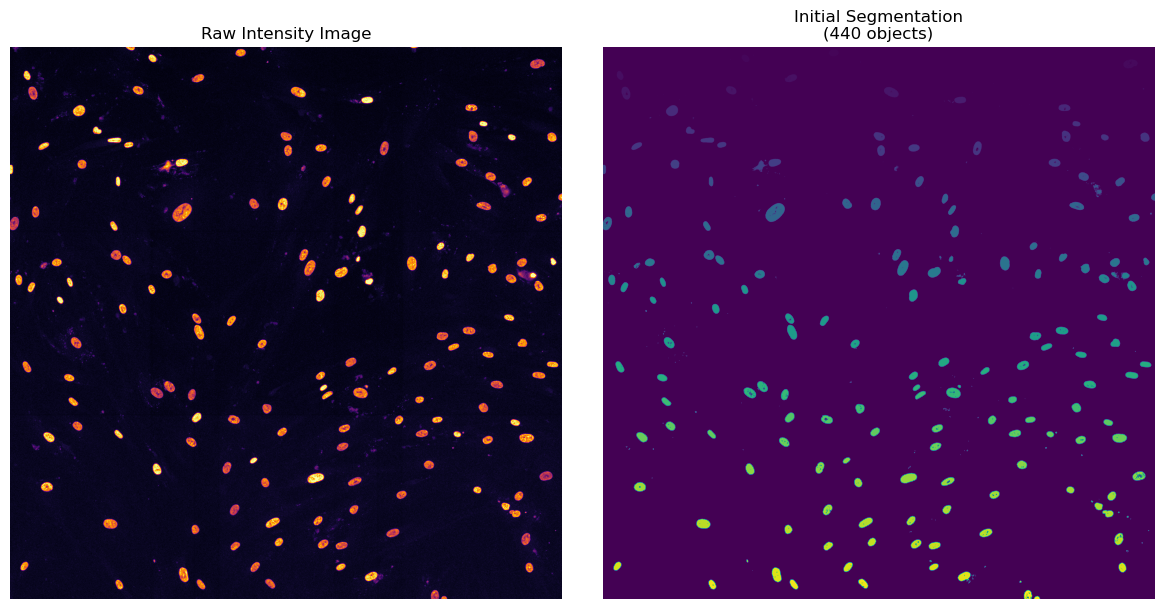

In [3]:
# Convert binary mask (0,255) → Labeled Image (1,2,3,...)
binary_mask = labelled_image > 0
labelled_image = measure.label(binary_mask, connectivity=2)

# Display the raw and labeled images
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.imshow(raw_image, cmap='inferno')
ax0.set_title("Raw Intensity Image")
ax0.axis('off')

ax1.imshow(labelled_image, cmap='viridis')
ax1.set_title(f"Initial Segmentation\n({labelled_image.max()} objects)")
ax1.axis('off')

plt.tight_layout()
plt.show()

## Filter Out Non-Nuclear Objects

Remove small particles and other noise that aren't true nuclei.

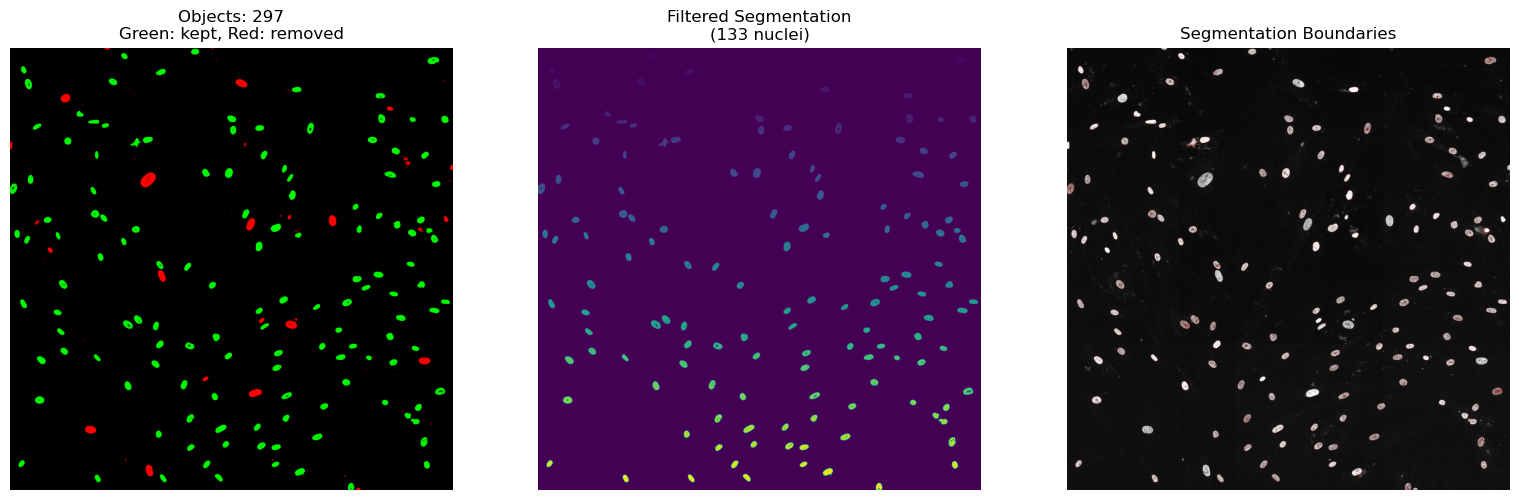

Before filtering: 297 objects
After filtering: 133 nuclei
Removed: 164 objects


In [ ]:
# Set thresholds for filtering
MIN_NUCLEUS_AREA = 4000  # Minimum area in pixels to be considered a nucleus
MAX_NUCLEUS_AREA = 12000  # Maximum area to exclude giant clumps/artifacts
MAX_ECCENTRICITY = 2.9   # Maximum eccentricity to exclude extremely elongated objects

# Get region properties
props_all = measure.regionprops(labelled_image, intensity_image=raw_image)

# Create a mask for valid nuclei
valid_nuclei_mask = np.zeros_like(labelled_image, dtype=bool)
valid_labels = []
invalid_labels = []

for prop in props_all:
    if MIN_NUCLEUS_AREA <= prop.area <= MAX_NUCLEUS_AREA and prop.eccentricity < MAX_ECCENTRICITY:
        # Additional filtering based on solidity if needed
        if prop.solidity > 0.8:  # Objects should be reasonably solid/filled
            valid_nuclei_mask[tuple(prop.coords.T)] = True
            valid_labels.append(prop.label)
    else:
        invalid_labels.append(prop.label)

# Relabel the filtered mask
filtered_labelled_image = measure.label(valid_nuclei_mask)

# Visualize the filtering results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original labeled image with color-coded filtering
overlay = np.zeros((*labelled_image.shape, 3))
for prop in props_all:
    if prop.label in valid_labels:
        # Valid nuclei in green
        overlay[labelled_image == prop.label] = [0, 1, 0]  
    else:
        # Invalid objects in red
        overlay[labelled_image == prop.label] = [1, 0, 0]  

axes[0].imshow(overlay)
axes[0].set_title(f'Objects: {len(props_all)}\nGreen: kept, Red: removed')
axes[0].axis('off')

# Filtered labeled image
axes[1].imshow(filtered_labelled_image, cmap='viridis')
axes[1].set_title(f'Filtered Segmentation\n({len(valid_labels)} nuclei)')
axes[1].axis('off')

# Show boundaries on raw image
boundaries = segmentation.find_boundaries(filtered_labelled_image)
rgb_raw = np.dstack([raw_image/raw_image.max()]*3)  # Convert to RGB
rgb_raw[boundaries] = [1, 0, 0]  # Red boundaries

axes[2].imshow(rgb_raw)
axes[2].set_title('Segmentation Boundaries')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Before filtering: {len(props_all)} objects")
print(f"After filtering: {len(valid_labels)} nuclei")
print(f"Removed: {len(invalid_labels)} objects")

# Update our labeled image with the filtered version
labelled_image = filtered_labelled_image.copy()

## Size Distribution Analysis

Visualize the size distribution of the filtered nuclei.

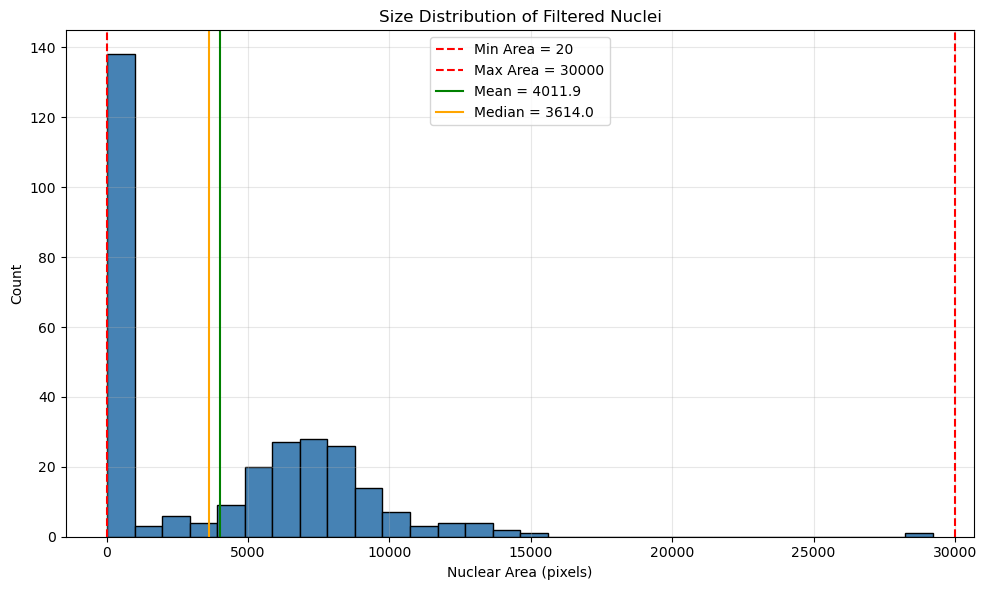

In [5]:
# Get region properties for the filtered image
props = measure.regionprops(labelled_image, intensity_image=raw_image)

# Extract nuclei areas
areas = [prop.area for prop in props]

# Plot size distribution
plt.figure(figsize=(10, 6))
plt.hist(areas, bins=30, color='steelblue', edgecolor='black')
plt.title('Size Distribution of Filtered Nuclei')
plt.xlabel('Nuclear Area (pixels)')
plt.ylabel('Count')
plt.axvline(MIN_NUCLEUS_AREA, color='red', linestyle='--', label=f'Min Area = {MIN_NUCLEUS_AREA}')
plt.axvline(MAX_NUCLEUS_AREA, color='red', linestyle='--', label=f'Max Area = {MAX_NUCLEUS_AREA}')
plt.axvline(np.mean(areas), color='green', linestyle='-', label=f'Mean = {np.mean(areas):.1f}')
plt.axvline(np.median(areas), color='orange', linestyle='-', label=f'Median = {np.median(areas):.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Extraction Function

Define a function to extract all features from a single nucleus.

In [10]:
def extract_nucleus_features(nucleus_properties):
    """
    Extract all features for a single nucleus
    
    Args:
        nucleus_properties: Properties of a single nucleus from regionprops
        
    Returns:
        DataFrame row with all the features for this nucleus
    """
    # Get binary mask and intensity image
    binary_mask = nucleus_properties.image
    intensity_img = nucleus_properties.intensity_image
    
    # Initialize features dictionary with the nucleus label
    features_dict = {'label': nucleus_properties.label}
    
    try:
        # 1. Basic regionprops features
        regionprops_features = {
            'area': nucleus_properties.area,
            'perimeter': nucleus_properties.perimeter,
            'eccentricity': nucleus_properties.eccentricity,
            'solidity': nucleus_properties.solidity,
            'equivalent_diameter': nucleus_properties.equivalent_diameter,
            'major_axis_length': nucleus_properties.major_axis_length,
            'minor_axis_length': nucleus_properties.minor_axis_length,
            'orientation': nucleus_properties.orientation,
        }
        features_dict.update(regionprops_features)
        
        # 2. Global morphology features
        morphology_features = BG.measure_global_morphometrics(binary_mask)
        features_dict.update(morphology_features.to_dict())
        
        # 3. Local boundary curvature features (use smaller step for small nuclei)
        step_size = 5 if nucleus_properties.area > 500 else 3
        curvature_features = BLC.measure_curvature_features(binary_mask, step=step_size)
        features_dict.update(curvature_features.to_dict())
        
        # 4. Intensity distribution features
        intensity_features = IDF.measure_intensity_features(binary_mask, intensity_img)
        features_dict.update(intensity_features.to_dict())
        
        # 5. Texture features
        texture_features = IT.measure_texture_features(binary_mask, intensity_img)
        features_dict.update(texture_features.to_dict())
        
        # Create dataframe from the dictionary
        return pd.DataFrame([features_dict])
        
    except Exception as e:
        print(f"Error processing nucleus {nucleus_properties.label}: {str(e)}")
        return None

## Process All Nuclei

Extract features from all valid nuclei in the image.

In [11]:
# Get region properties for the filtered image
props = measure.regionprops(labelled_image, intensity_image=raw_image)

# Initialize empty dataframe for all nuclei features
all_nuclei_features = pd.DataFrame()

# Process each nucleus with a progress bar
print(f"Extracting features from {len(props)} nuclei...")

for i, prop in enumerate(tqdm(props)):
    # Extract features for this nucleus
    nucleus_features = extract_nucleus_features(prop)
    
    # If successful, add to the master dataframe
    if nucleus_features is not None:
        all_nuclei_features = pd.concat([all_nuclei_features, nucleus_features], ignore_index=True)
    
    # Optional: Display progress update every 20 nuclei
    if (i+1) % 20 == 0:
        print(f"Processed {i+1}/{len(props)} nuclei")

print(f"Successfully extracted features from {len(all_nuclei_features)} nuclei")

Extracting features from 133 nuclei...


  0%|          | 0/133 [00:00<?, ?it/s]

Processed 20/133 nuclei
Processed 40/133 nuclei
Processed 60/133 nuclei
Processed 80/133 nuclei
Processed 100/133 nuclei
Processed 120/133 nuclei
Successfully extracted features from 133 nuclei


## Save Results to CSV

Save the extracted features to a CSV file.

In [12]:
# Generate filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base_filename = os.path.basename(raw_image_path).split('.')[0]
csv_filename = f"{base_filename}_features_{timestamp}.csv"
csv_path = os.path.join(output_folder, csv_filename)

# Save to CSV
all_nuclei_features.to_csv(csv_path, index=False)
print(f"Features saved to: {csv_path}")

# Display summary of the features
print(f"\nFeature set contains {len(all_nuclei_features)} nuclei with {len(all_nuclei_features.columns)} features per nucleus")
print(f"\nFeature categories:")
print(f"Basic regionprops features: area, perimeter, eccentricity, etc.")
print(f"Global morphology features: caliper_length, sphericity, etc.")
print(f"Boundary curvature features: curvature_mean, curvature_std, etc.")
print(f"Intensity features: median_intensity, hetero_ratio, etc.")
print(f"Texture features: glcm_contrast, glcm_correlation, etc.")

Features saved to: D:\Acad 3 - 2\Project\chrometrics\results\008_G10_raw_features_20250318_005509.csv

Feature set contains 133 nuclei with 202 features per nucleus

Feature categories:
Basic regionprops features: area, perimeter, eccentricity, etc.
Global morphology features: caliper_length, sphericity, etc.
Boundary curvature features: curvature_mean, curvature_std, etc.
Intensity features: median_intensity, hetero_ratio, etc.
Texture features: glcm_contrast, glcm_correlation, etc.
